<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

#  Feature scaling

In [3]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [5]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# Feature engineering

In [6]:
data = mf.feature_engineering(data)
data = mf.feature_scaling(data)

# One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [7]:
data = pd.get_dummies(data)

In [8]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [9]:
# data = mf.select_days(data, 60)

In [10]:
load = False
save_id = True 

if load:
  X_train, y_train = mf.get_set('train_id', data, 'xgboost_numpy', labels = True)
  X_val, y_val = mf.get_set('val_id', data, 'xgboost_numpy', labels = True)
  X_test, y_test = mf.get_set('test_id', data, 'xgboost_numpy', labels = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Splitto il dataset in train, validation e test set. 

In [11]:
if not load:
  X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
  del data
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [12]:
if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

# load_id = False 
# if load_id:
#   mf.load_list('train_id',train_id)
#   mf.load_list('val_id', val_id)
#   mf.load_list('test_id', test_id)

# Undersampling: Easy Ensemble

L'easy ensemble tramite un metodo unsupervised divide il dataset in diversi dataset undersampled. 

Documentazione easy ensemble: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.ensemble.EasyEnsemble.html#imblearn.ensemble.EasyEnsemble

Esempio applicazio ee: http://glemaitre.github.io/imbalanced-learn/auto_examples/ensemble/plot_easy_ensemble.html?highlight=easy%20ensemble

In [13]:
# X_trainres, y_trainres = mf.easy_ensemble(5, X_train, y_train)

In [14]:
# X_trainres_df = pd.DataFrame(data = X_trainres[0], columns = cols)
# del X_trainres

# XGBoost

ROC curve: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-roc-curve-visualization-api-py

XGBoost: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

gpu_hist method: https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-hist-and-gpu-hist-tree-method

## Load model

Riferimento: https://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [15]:
if load:
  from joblib import load
  from xgboost import XGBClassifier

  clf = load("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/xgboost_numpy/xgb_np.joblib.dat")

## Training

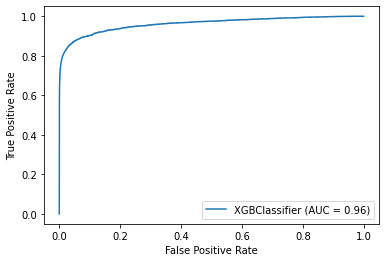

In [16]:
from sklearn.metrics import plot_roc_curve
import xgboost as xgb
from xgboost import XGBClassifier

if not load:
  clf = XGBClassifier(n_estimators = 4000, max_depth = 10, 
                      objective='binary:logistic', learning_rate = 0.5, 
                      tree_method='gpu_hist') 
  
  clf.fit(X_train.to_numpy(), y_train.to_numpy())

plot_roc_curve(clf, X_val.to_numpy(), y_val.to_numpy())
plt.show()

# Save model

In [17]:
save = True
if save:
  from joblib import dump
  dump(clf, "xgb_np.joblib.dat")

# Perfomance evaluation

## Confusion matrix

[[113697    156]
 [  1372   2882]]


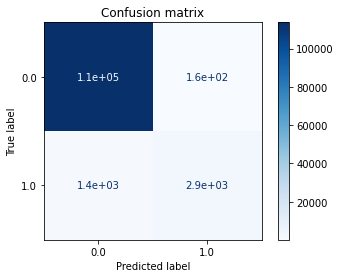

In [18]:
mf.conf_matrix(clf, X_val.to_numpy(), y_val.to_numpy())

## Mean average precision

AP max = 0.84

AP: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

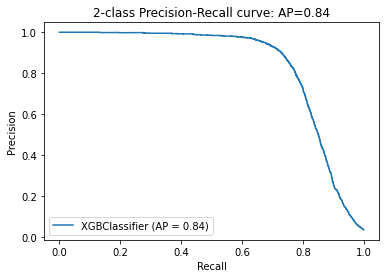

In [19]:
mf.ap_metric(clf, X_val.to_numpy(), y_val.to_numpy(), proba = True)

## Feature importance

Cambio il nome delle feature assegnato di default da xgboost quando viene trainato su un array numpy. 

Riferimento: https://stackoverflow.com/questions/54933804/how-to-get-actual-feature-names-in-xgboost-feature-importance-plot-without-retra

In [21]:
clf.get_booster().feature_names = cols

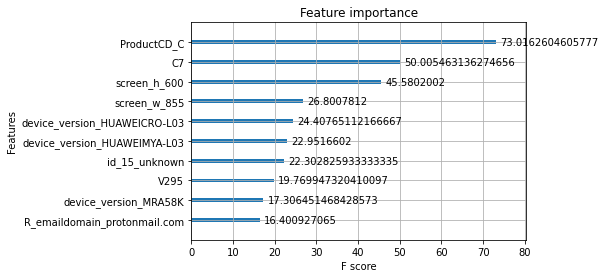

In [22]:
xgb.plot_importance(clf, max_num_features = 10, importance_type='gain')

# Loss evaluation by day

In [ ]:
def loss_by_day(X_test, clf):
  y_pred = clf.predict_proba(X_test)
  



In [23]:
y_pred = clf.predict_proba(X_test)

In [26]:
y_pred

array([[9.9999994e-01, 7.3652039e-08],
       [9.9999982e-01, 1.5144315e-07],
       [1.0000000e+00, 4.5218957e-09],
       ...,
       [9.9963075e-01, 3.6924274e-04],
       [4.8699379e-03, 9.9513006e-01],
       [9.9999964e-01, 3.3959151e-07]], dtype=float32)

In [37]:
X_train[X_train['day'] != 6.0]

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,...,screen_h_732,screen_h_740,screen_h_750,screen_h_756,screen_h_759,screen_h_767,screen_h_768,screen_h_774,screen_h_792,screen_h_800,screen_h_801,screen_h_803,screen_h_809,screen_h_810,screen_h_819,screen_h_837,screen_h_840,screen_h_844,screen_h_845,screen_h_857,screen_h_864,screen_h_880,screen_h_889,screen_h_899,screen_h_900,screen_h_901,screen_h_922,screen_h_924,screen_h_941,screen_h_944,screen_h_945,screen_h_946,screen_h_947,screen_h_960,screen_h_971,screen_h_972,screen_h_973,screen_h_975,screen_h_990,screen_h_992


In [38]:
X_train['hour']

120202    0.0
312008    0.0
374211    0.0
383722    0.0
205067    0.0
         ... 
172172    0.0
546704    0.0
83099     0.0
317935    0.0
243752    0.0
Name: hour, Length: 354319, dtype: float64